# Ερώτηση 3 (Clustering)

## Loading data

In [1]:
import pandas as pd
import numpy as np
import json
import time 

yelp_dataset_path = '../yelp-dataset/'
buisness_v_path = yelp_dataset_path + 'yelp_academic_dataset_business.json'
leftK_path = '/home/left/Desktop/dataMining/set2/ask2/yelp_academic_dataset_business.json'

dataset_business = []
categories_order = ["Beauty & Spas", "Shopping", "Bars"]

start = time.time()

with open(buisness_v_path, 'r', encoding="utf8") as buisness_file:
    for line in buisness_file:
        json_dict = json.loads(line)
        if  json_dict['city'] == 'Toronto' and \
            json_dict['review_count'] > 10 and \
            json_dict['categories'] is not None and \
            any(word in json_dict['categories'] for word in categories_order):
                temp_cat = [cat for cat in categories_order if cat in json_dict['categories']][0]
                dataset_business.append([json_dict['business_id'], temp_cat])
                

stop = time.time()
print("Read file in {} seconds".format(stop-start))

Read file in 3.813101291656494 seconds


In [2]:
np_business = np.array(dataset_business)
np_business_id = np_business[:,0]

In [3]:
def get_index(business_id):
    index = np.where(np_business_id == business_id)[0]
    return index

In [4]:
start = time.time()
business_review_txt = [[] for i in range(int(len(np_business)))]
review_v_path = yelp_dataset_path + 'yelp_academic_dataset_review.json'
leftK_path = '/home/left/Desktop/dataMining/set2/ask2/yelp_academic_dataset_review.json'

with open(review_v_path, 'r', encoding="utf8") as reviews_file:
    for line in reviews_file:
        json_dict = json.loads(line)
        index = get_index(json_dict['business_id'])
        if index.size > 0:
            if len(business_review_txt[index[0]]) == 0:
               business_review_txt[index[0]] = json_dict['text']
            else:
               business_review_txt[index[0]] += json_dict['text']
        # if json_dict['business_id'] in np_business:
        #     if json_dict['business_id'] in business_review_txt:
        #         business_review_txt[json_dict['business_id']] += json_dict['text']
        #     else:
        #         business_review_txt[json_dict['business_id']] = json_dict['text']


stop = time.time()

print("Read file in {} mins".format((stop-start)/60))

Read file in 5.447769939899445 mins


## TF-IDF

In [246]:
from sklearn.feature_extraction import text

# 
def preprocessor(text):
    text=text.lower() 
    text=re.sub("\\W"," ",text) # remove special chars
    text=re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ",text) # normalize certain words
    return text

# Load custom stopwords    
with open('stopwords.txt', 'r') as text_file:
    lines = text_file.read().split('\n')

stop_words = lines

In [295]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df = 0.75,
                        min_df = 0.25,
                        max_features = 8000,
                        stop_words = stop_words,
                        token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b') #makes sure it matches a word                                                    # but contains at least one letter
                                                 # this is done to remove numbers
tfidf.fit(business_review_txt)
fitted_vectorizer = tfidf.transform(business_review_txt)

In [296]:
# show words that were eliminated
df_idf = pd.DataFrame(tfidf.idf_, index=tfidf.get_feature_names(),columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights']) 

,idf_weights
customer,1.290749
minutes,1.292388
friend,1.298972
thought,1.299385
visit,1.307681
...,...
eventually,2.380798
brown,2.380798
fall,2.383237
walls,2.384459


In [297]:
# show words that are included
tfidf.vocabulary_

{'side': 677,
 'checked': 111,
 'restaurant': 619,
 'extra': 240,
 'across': 4,
 'parking': 525,
 'expensive': 235,
 'served': 664,
 'low': 422,
 'exactly': 228,
 'arrive': 31,
 'early': 207,
 'prepared': 571,
 'second': 654,
 'visit': 808,
 'slightly': 690,
 'least': 395,
 'cooked': 147,
 'piece': 545,
 'cut': 166,
 'turn': 792,
 'dry': 204,
 'bland': 62,
 'rare': 594,
 'inside': 367,
 'couldn': 151,
 'ambiance': 17,
 'perfect': 535,
 'event': 226,
 'unfortunately': 800,
 'food': 277,
 'classic': 123,
 'years': 860,
 'live': 409,
 'building': 82,
 'spent': 709,
 'odd': 494,
 'haven': 328,
 'heard': 331,
 'highly': 340,
 'dinner': 184,
 'location': 413,
 'choices': 119,
 'ok': 500,
 'order': 511,
 'treat': 784,
 'birthday': 59,
 'complaints': 140,
 'waiter': 812,
 'check': 110,
 'brought': 79,
 'free': 281,
 'dessert': 180,
 'choice': 118,
 'meal': 435,
 'gave': 294,
 'friend': 285,
 'bowl': 71,
 'salad': 637,
 'liked': 403,
 'server': 665,
 'average': 41,
 'tender': 760,
 'days': 171,

## Kmeans

In [298]:
from sklearn.cluster import KMeans
import sklearn.cluster as sk_cluster
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=3, n_init=25, max_iter=600, random_state=42)
kmeans.fit_predict(fitted_vectorizer)
y_pred = kmeans.labels_
centroids = kmeans.cluster_centers_
error = kmeans.inertia_

Total error: 1992.4197281666238
Cluster Centroids: 
[[0.01278304 0.00486085 0.01634301 ... 0.00507575 0.00687259 0.01508504]
 [0.01531346 0.00497545 0.01531255 ... 0.00697429 0.0063623  0.00030698]
 [0.02473615 0.00542279 0.01827027 ... 0.00971577 0.01032593 0.00205247]]


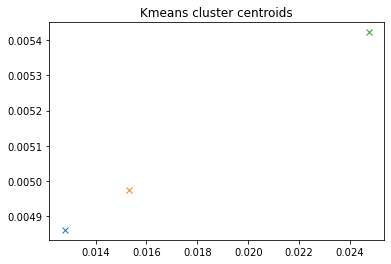

In [299]:
# General information
print("Total error: {}".format(error))
print("Cluster Centroids: \n{}".format(centroids))

for centroids in kmeans.cluster_centers_:
    plt.plot(centroids[0], centroids[1], marker='x')
plt.title('Kmeans cluster centroids')
plt.show()

0: 1705, 1: 757, 2: 803, sum: 3265
Confusion matrix : 
[[1542    0  163]
 [   2  270  485]
 [  51    0  752]]


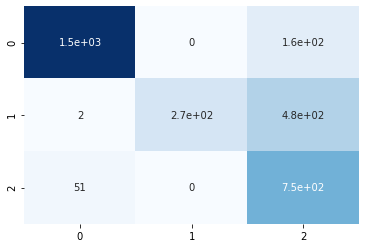

Precision : [0.96677116 1.         0.53714286]
Recall : [0.90439883 0.35667107 0.93648817]


In [300]:
# True values table: Μatching categories to numbers
true_labels = np_business[:,1]
for i in range(len(true_labels)):
    if true_labels[i]=='Bars':
        true_labels[i]=0
    if true_labels[i]=='Beauty & Spas':
        true_labels[i]=1
    if true_labels[i]=='Shopping':
        true_labels[i]=2
    
true_labels = [int(i) for i in true_labels] 
n0 = true_labels.count(0)
n1 = true_labels.count(1)
n2 = true_labels.count(2)
print('0: {}, 1: {}, 2: {}, sum: {}'.format(n0, n1, n2, n0+n1+n2))

# Confusion matrix
cf_matrix = confusion_matrix(true_labels, y_pred)

print("Confusion matrix : \n{}".format(cf_matrix))
sns.heatmap(cf_matrix,  annot=True, 
                        cmap='Blues',
                        cbar=False)
plt.show()

# Precision - Recall
precision = metrics.precision_score(true_labels, y_pred, average=None)
recall = metrics.recall_score(true_labels, y_pred, average = None)

print("Precision : {}".format(precision))
print("Recall : {}".format(recall))


[0, 1, 2]
Confusion matrix : 
[[1542    0  163]
 [   2  270  485]
 [  51    0  752]]


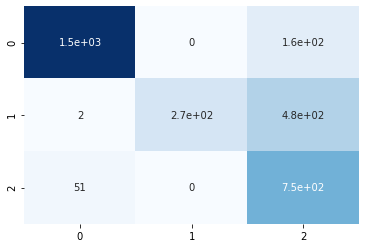

Precision : [0.96677116 1.         0.53714286]
Recall : [0.90439883 0.35667107 0.93648817]


In [301]:
# x_axis_labels = ['Bars', 'Beauty & Spas', 'Shopping'] 
# y_axis_labels = [0, 1, 2] 
# ,
#                         xticklabels=x_axis_labels, 
#                         yticklabels=y_axis_labels

mapping = list(np.argmax(cf_matrix, axis=0))
print(mapping)

mapped_kmeans_labels = [0 for i in range(len(y_pred))]
for i in range(len(y_pred)):
    mapped_kmeans_labels[i] = mapping[y_pred[i]]

cf_matrix = confusion_matrix(true_labels, mapped_kmeans_labels)
print("Confusion matrix : \n{}".format(cf_matrix))
sns.heatmap(cf_matrix,  annot=True, 
                        cmap='Blues',
                        cbar=False)
plt.show()

# Precision - Recall
precision = metrics.precision_score(true_labels, y_pred, average=None)
recall = metrics.recall_score(true_labels, y_pred, average = None)

print("Precision : {}".format(precision))
print("Recall : {}".format(recall))


Clusters 2, score 0.136
Clusters 3, score 0.156
Clusters 4, score 0.161
Clusters 5, score 0.111
Clusters 6, score 0.112
Clusters 7, score 0.103


Text(0, 0.5, 'Error')

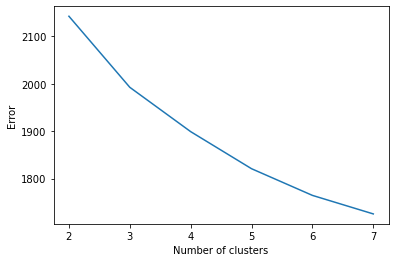

In [302]:
from sklearn.metrics import silhouette_score

n_clusters = 7
error = np.zeros(n_clusters+1)
error[0] = 0
max_score = 0
f_clasters = 0
score = np.zeros(n_clusters+1)
for k in range(2,n_clusters+1):
    kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=25, max_iter=600,  random_state=42)
    preds = kmeans.fit_predict(fitted_vectorizer)
    error[k] = kmeans.inertia_
    score[k] = silhouette_score(fitted_vectorizer, preds)
    print('Clusters {}, score {:.3f}'.format(k, score[k]))
    if (score[k] > max_score):
        f_clasters = k 
        max_score = score[k]

plt.plot(range(2,len(error)),error[2:])
#plt.plot(range(2,len(score)),score[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

In [303]:
def cfm_show(cf_matrix):
    sns.heatmap(cf_matrix,  annot=True, 
                            cmap='Blues',
                            cbar=False)
    plt.show()

def Kmeans_winfo(n_clusters, true_labels, data):
    kmeans = sk_cluster.KMeans(init='k-means++', 
                            n_clusters=n_clusters, 
                            n_init=25, 
                            max_iter=600,  
                            random_state=42)
    predictions = kmeans.fit_predict(data)
    centroids = kmeans.cluster_centers_
    error = kmeans.inertia_
    score = silhouette_score(fitted_vectorizer, predictions)
    cfm = confusion_matrix(true_labels, predictions)        # Without mapping
    precision = metrics.precision_score(true_labels, predictions, average=None)
    recall = metrics.recall_score(true_labels, predictions, average = None)

    # Display info
    for centroids in kmeans.cluster_centers_:
        plt.plot(centroids[0], centroids[1], marker='x')
    plt.title('Kmeans cluster centroids')
    plt.show()

    print("Confusion matrix : \n{}".format(cfm))
    cfm_show(cfm)

    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("Score : {}".format(score))

In [304]:
#Kmeans_winfo(4, true_labels,)

In [305]:
# from sklearn.metrics import silhouette_samples, silhouette_score

# for n_clusters in range(2, 11):
#     kmeans = KMeans(n_clusters=n_clusters)
#     cluster_labels = kmeans.fit_predict(fitted_vectorizer)

#     silhouette_avg = silhouette_score(fitted_vectorizer, cluster_labels)
#     print("For n_clusters =", n_clusters,
#             "The average silhouette_score is :", silhouette_avg)

In [306]:
# data_for_agglo = fitted_vectorizer.todense()

# from sklearn.cluster import AgglomerativeClustering
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='ward')
# predictions = agglomerative.fit_predict(data_for_agglo)


# # MAKE CONF MATRIX HERE FOR 'WARD' PREC/REC ETC.

In [307]:
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='complete')
# predictions = agglomerative.fit_predict(data_for_agglo)

# MAKE CONF MATRIX HERE FOR ;COMPLETE' PREC/REC ETC.

In [308]:
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='average')
# predictions = agglomerative.fit_predict(data_for_agglo)

# MAKE CONF MATRIX HERE FOR 'AVERAGE' PREC/REC ETC.

In [309]:
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='single')
# predictions = agglomerative.fit_predict(data_for_agglo)

# # MAKE CONF MATRIX HERE FOR 'SINGLE' PREC/REC ETC.

In [310]:
# print(predictions)